<a href="https://colab.research.google.com/github/jocelynbaduria/cmpe-297_SOTA/blob/main/Jocelyn_Baduria_SimCLR_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ReadMe:

How to do Contrastive Learning SimCLR using Pytorch in Colaboratory

1. Clone the sample code from the github for reproducibilty, experimentation and understanding. Save it to gdrive.
   Refer github Code: https://github.com/thunderInfy/simclr
  
2. Run the SimCLR code in colab using the terminal command and make sure you are connected to CUDA for reproducibility.
3. Results using CUDA in Colab with not enough memory. Reuse the trained model save in results folder and imagenet-5-categories images.
4. Prepare the training datasets with class AugmentedDataset with color jitter and random resize crop.
5. Check the images if can be read properly for train and test set sample.
6. Load the augmented images with batch size of 250
7. Plot the TSNE visualization
8. Perform Linear Classifier with visualization of training/test accuracy/losses.

    

### Run the SimCLR code in PyTorch using Colab terminal

In [1]:
import torch
import torchvision

In [2]:
# Confirm that we can connect to GPU, https://navidre.medium.com/pytorch-in-google-colab-640e5d166f13
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Torch 1.9.0+cu102 CUDA 10.2
Device: cuda:0


In [4]:
!sudo fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia0:        root         79 F...m python3
/dev/nvidiactl:      root         79 F.... python3
/dev/nvidia-uvm:     root         79 F.... python3


In [5]:
!nvidia-smi

Sat Sep 25 22:35:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Run the code using the appropriate command from github clone code in colab terminal
# This command would do the self-supervised training on the dataset at '../milli_imagenet' and store the results in the 'results' directory.
# The training batch size is 250, cuda and multiple gpus are used.
# Results the CUDA cannot do the autograd function using training batch size of 250.
!python /content/drive/MyDrive/simclr/main.py '/content/drive/MyDrive/milli_imagenet' '/content/drive/MyDrive/simclr/results' -bs 250 -c --multiple_gpus &

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Traceback (most recent call last):
  File "/content/drive/MyDrive/simclr/main.py", line 80, in <module>
    simclrobj.train(args, 10, 1)
  File "/content/drive/MyDrive/simclr/simclr.py", line 101, in train
    loss.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
RuntimeError: CUDA ou

### Results using CUDA in Colab with not enough memory. Reuse the trained model save in results folder and imagenet-5-categories images.

In [ ]:
# Getting the dataset from the github repo of imagenet 5 categories
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.96 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Imports some module ( requests, zipfile, io) to get the resnet SimCLR results folder
import requests
import zipfile
import io

In [ ]:
# Extracts the simCLR trained model from results folder
r = requests.get('https://github.com/thunderInfy/resnet-simclr/blob/master/results.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()   

In [ ]:
# Imports module to perform the SimCLR, image augmentation and Linear classification training using the trained save model.

import numpy as np
import torch
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18


import os
from PIL import Image
from collections import OrderedDict

# added imports to show images
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io

import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

### Prepare the training datasets with class AugmentedDataset with color jitter and random resize crop.

In [ ]:
# device is set to cuda if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# root folder is the name of the folder where data is contained
root_folder = 'imagenet-5-categories'

train_names = sorted(os.listdir(root_folder + '/train'))
test_names = sorted(os.listdir(root_folder + '/test'))

# setting random seed to ensure the same 10% labelled data is used when training the linear classifier
random.seed(0)

names_train_10_percent = random.sample(train_names, len(train_names) // 10)
names_train = random.sample(train_names, len(train_names))
names_test = random.sample(test_names, len(test_names))

In [ ]:
# model = models.resnet18()
print(torch.cuda.memory_allocated())

0


In [ ]:
# defining a mapping between class names and numbers
mapping = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
inverse_mapping = ['car', 'dog', 'elephant', 'cat', 'airplane']

# get the labels based on the filenames with classnames. These labels won't be used to train the base model
# These are just for visualization purposes
labels_train = [mapping[x.split('_')[0]] for x in names_train]
labels_test = [mapping[x.split('_')[0]] for x in names_test]

# these 10 percent labels will be used for training the linear classifer
labels_train_10_percent = [mapping[x.split('_')[0]] for x in names_train_10_percent]

In [ ]:
# A function to perform color distortion in images
# It is used in SimCLR alongwith random resized cropping
# Here, s is the strength of color distortion.

def get_color_distortion(s=1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    
    # p is the probability of grayscale, here 0.2
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

In [ ]:
# This is the class for image augmentation

class MyDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        image = T.Resize((250, 250))(image)
        # Data Augmentation two images with RandomResizedCrop and get_color_distortion
        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample

In [ ]:
# datasets with augmentation
training_dataset_mutated = MyDataset(root_folder + '/train', names_train, labels_train, mutation=True)
training_dataset = MyDataset(root_folder + '/train', names_train_10_percent, labels_train_10_percent, mutation=False)
testing_dataset = MyDataset(root_folder + '/test', names_test, labels_test, mutation=False)

### Check the images if can be read properly for train and test set sample.

In [ ]:
print(names_train)

['airplane_257796960_f2b410e9cd.jpg', 'airplane_177530215_e02f05a596.jpg', 'car_1260299128_28a71aa96a.jpg', 'car_2570822777_30d2c5d3cc.jpg', 'elephant_86751520_246de2a54e.jpg', 'elephant_456668125_c70bba9f72.jpg', 'airplane_88395459_992dabe764.jpg', 'dog_1589046073_5420d1ca1d.jpg', 'airplane_370787033_d838df6f2c.jpg', 'dog_1114031303_03c6f21c53.jpg', 'airplane_73548780_045db11599.jpg', 'airplane_201055683_76e5149bec.jpg', 'airplane_1569870247_963a142dea.jpg', 'car_2583556570_6bf3197b8c.jpg', 'car_2511386544_d1590e73f7.jpg', 'car_1259513947_cfff1b7336.jpg', 'dog_78038346_2ce4cb65d5.jpg', 'car_263312993_d7cf3ab79c.jpg', 'airplane_2393186173_5df8796c80.jpg', 'airplane_1589413077_f20f02bbae.jpg', 'elephant_235118168_bda7675339.jpg', 'dog_312943903_aa0b5a8c05.jpg', 'airplane_432305973_7ecbe9d2c4.jpg', 'cat_131001499_e6f50809db.jpg', 'airplane_2554751290_7613d32839.jpg', 'car_2684679529_97ccf686de.jpg', 'airplane_2562732252_afa2c90e21.jpg', 'cat_288847186_f720ea4e1e.jpg', 'cat_75714427_07216

In [ ]:
print(labels_train)

[4, 4, 0, 0, 2, 2, 4, 1, 4, 1, 4, 4, 4, 0, 0, 0, 1, 0, 4, 4, 2, 1, 4, 3, 4, 0, 4, 3, 3, 1, 0, 2, 2, 1, 4, 4, 2, 0, 2, 3, 1, 2, 0, 0, 4, 0, 0, 3, 2, 3, 4, 1, 0, 4, 1, 1, 2, 2, 3, 3, 1, 2, 0, 2, 4, 1, 4, 3, 4, 2, 3, 0, 0, 1, 3, 3, 3, 0, 3, 1, 1, 4, 4, 0, 3, 0, 0, 0, 1, 1, 2, 4, 1, 1, 4, 0, 1, 4, 3, 0, 1, 2, 1, 4, 4, 2, 3, 3, 2, 4, 1, 0, 2, 4, 0, 4, 1, 1, 3, 4, 0, 4, 4, 2, 4, 0, 4, 0, 3, 3, 0, 4, 1, 1, 4, 2, 3, 1, 2, 3, 0, 2, 3, 4, 0, 3, 4, 4, 4, 0, 3, 3, 1, 2, 2, 1, 1, 1, 0, 0, 1, 3, 4, 0, 0, 3, 3, 3, 1, 4, 3, 4, 4, 3, 0, 0, 3, 3, 1, 0, 3, 2, 1, 2, 4, 3, 0, 4, 2, 1, 3, 3, 1, 4, 4, 1, 1, 3, 3, 2, 2, 2, 2, 1, 4, 3, 3, 0, 0, 2, 4, 4, 4, 0, 2, 2, 1, 4, 2, 1, 3, 1, 2, 0, 1, 4, 1, 4, 2, 2, 3, 2, 2, 0, 4, 2, 4, 4, 1, 1, 2, 3, 4, 1, 3, 0, 1, 3, 2, 4, 3, 0, 0, 4, 3, 4, 2, 1, 4, 3, 4, 4, 4, 0, 0, 0, 3, 1, 4, 1, 3, 0, 2, 3, 0, 3, 3, 0, 1, 3, 3, 3, 2, 1, 0, 1, 3, 2, 3, 2, 1, 2, 2, 3, 1, 4, 4, 0, 3, 1, 1, 0, 1, 0, 4, 3, 1, 1, 0, 3, 1, 4, 1, 0, 2, 0, 2, 3, 1, 0, 4, 1, 2, 3, 1, 4, 1, 4, 4, 4, 0, 4, 1, 

In [ ]:
print(names_train_10_percent)

['dog_1407995394_22d8274d95.jpg', 'dog_298325020_925ce65f7c.jpg', 'airplane_2110882407_db1564e294.jpg', 'cat_130028450_3bea7e5120.jpg', 'elephant_1476324821_d53eeef43f.jpg', 'dog_959590073_b411321069.jpg', 'dog_2021522094_e3998b18e0.jpg', 'cat_299837288_5c84203463.jpg', 'dog_690883918_0a2ebf2d4a.jpg', 'cat_809663020_7ce9d0899f.jpg', 'elephant_518813412_12505cf38a.jpg', 'car_2666463976_54eedf3bb0.jpg', 'elephant_1371597085_668b079f8d.jpg', 'car_2060217143_9725741a28.jpg', 'cat_201964852_1817e956c1.jpg', 'car_2060326215_d0289b872e.jpg', 'airplane_388364587_64b2370a82.jpg', 'cat_1130458060_b77117482a.jpg', 'elephant_1919497998_3ca0e4b024.jpg', 'elephant_81317196_a96223ef04.jpg', 'car_2224497766_1de83768a7.jpg', 'cat_371068935_af213116ce.jpg', 'airplane_420257932_91a79f131f.jpg', 'airplane_257796960_f2b410e9cd.jpg', 'cat_495308681_e317861b3e.jpg', 'dog_515415369_5b5258ea94.jpg', 'elephant_342367081_234bf66913.jpg', 'airplane_425399322_b8c9f3facf.jpg', 'cat_797614305_bec61c42af.jpg', 'dog_3

In [ ]:
print(labels_train_10_percent)

[1, 1, 4, 3, 2, 1, 1, 3, 1, 3, 2, 0, 2, 0, 3, 0, 4, 3, 2, 2, 0, 3, 4, 4, 3, 1, 2, 4, 3, 1, 3, 0, 2, 1, 2, 3, 4, 2, 4, 4, 1, 4, 2, 3, 0, 3, 4, 0, 2, 0, 0, 0, 2, 1, 4, 4, 3, 2, 2, 4, 3, 2, 3, 0, 2, 3, 2, 0, 2, 2, 2, 3, 1, 4, 2, 3, 2, 0, 3, 0, 0, 0, 4, 3, 1, 4, 4, 0, 0, 4, 2, 1, 2, 3, 2, 0, 0, 2, 1, 2, 3, 1, 2, 3, 4, 3, 4, 1, 2, 3, 0, 0, 4, 3, 4, 0, 1, 0, 1, 0, 0, 4, 2, 2, 2]


In [ ]:
print(names_test)

['dog_948952651_ae88267702.jpg', 'elephant_1512248794_a732f0d77c.jpg', 'dog_411390999_7097d3634b.jpg', 'car_2431152745_eecfa49641.jpg', 'elephant_543215461_c0496c4ba6.jpg', 'car_2373896064_3acf6117fa.jpg', 'cat_512411718_da2e0a277d.jpg', 'cat_468615076_a2450bf20b.jpg', 'cat_54452243_48ce039967.jpg', 'car_2549993855_dbe4530875.jpg', 'car_2667096806_0d41ea9338.jpg', 'airplane_661682258_52d55b9cf5.jpg', 'dog_406630010_dfdcd4221e.jpg', 'elephant_1095153437_a6fb001195.jpg', 'cat_157662884_8e2d1dd295.jpg', 'elephant_11543351_3c9cca11b0.jpg', 'airplane_2885315_db5dd13d26.jpg', 'elephant_171252662_0177a9b8c6.jpg', 'airplane_108887665_86a1047ae4.jpg', 'dog_470186220_7595143e12.jpg', 'cat_439881434_c4d255c21c.jpg', 'airplane_389068663_68b8cef101.jpg', 'elephant_444085033_c4fe2dc8c4.jpg', 'dog_2090987318_31b245a26b.jpg', 'dog_366070882_1419a396aa.jpg', 'elephant_257264886_d95791f5e7.jpg', 'cat_776126883_5bce88df32.jpg', 'car_847154336_f782942022.jpg', 'car_2735375964_9226b2ea80.jpg', 'cat_2095245

In [ ]:
print(labels_test)

[1, 2, 1, 0, 2, 0, 3, 3, 3, 0, 0, 4, 1, 2, 3, 2, 4, 2, 4, 1, 3, 4, 2, 1, 1, 2, 3, 0, 0, 3, 4, 3, 3, 1, 1, 2, 2, 1, 0, 4, 2, 3, 4, 1, 4, 1, 0, 1, 2, 3, 2, 1, 1, 0, 3, 0, 0, 4, 3, 4, 1, 3, 0, 1, 3, 2, 2, 4, 2, 4, 3, 4, 3, 2, 3, 0, 0, 3, 0, 1, 0, 4, 0, 4, 3, 4, 1, 0, 1, 2, 1, 0, 2, 3, 3, 2, 3, 4, 2, 2, 2, 4, 2, 3, 3, 4, 4, 4, 0, 2, 2, 4, 1, 4, 3, 4, 0, 3, 1, 3, 1, 1, 3, 0, 4, 0, 3, 1, 2, 2, 0, 1, 3, 1, 1, 3, 2, 1, 0, 1, 0, 3, 4, 0, 2, 2, 1, 1, 2, 0, 0, 3, 2, 1, 4, 0, 2, 3, 3, 4, 4, 1, 1, 4, 3, 2, 2, 2, 1, 0, 3, 2, 2, 0, 2, 1, 0, 2, 2, 4, 1, 4, 2, 1, 3, 2, 1, 0, 1, 4, 4, 1, 3, 0, 0, 4, 4, 0, 3, 2, 3, 4, 4, 0, 2, 3, 0, 0, 1, 0, 2, 4, 3, 3, 2, 2, 4, 4, 4, 0, 4, 4, 0, 4, 1, 4, 2, 1, 0, 1, 1, 4, 0, 4, 1, 3, 3, 1, 0, 3, 4, 2, 3, 1, 0, 0, 4, 0, 0, 3]


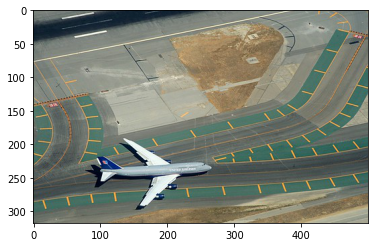

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/imagenet-5-categories/train/airplane_257796960_f2b410e9cd.jpg','r')
imshow(np.asarray(pil_im))

### Load the augmented images with batch size of 250

In [ ]:
# dataloading of images with data augmentation
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=250, shuffle=True, num_workers=2)
dataloader_training_dataset = DataLoader(training_dataset, batch_size=125, shuffle=True, num_workers=2)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=250, shuffle=True, num_workers=2)

In [ ]:
# Use pretrained Resnet18 deep learning model architecture
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnet.fc = classifier

In [ ]:
# can view the summary if you like
# summary(resnet, (3, 224, 224))

In [ ]:
# moving the resnet architecture to device
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Initialize the NT-Xent Loss function.

tau = 0.05

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [ ]:
# Load the stored training from results folder from the github https://github.com/thunderInfy/resnet-simclr/blob/master/results.zip?raw=true to save 
# GPU memory loading

losses_train = []
num_epochs = 10

# using SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')

# load pretrained model, optimizer and training losses file if model.pth file is available
if(os.path.isfile("results/model.pth")):
    resnet.load_state_dict(torch.load("results/model.pth"))
    optimizer.load_state_dict(torch.load("results/optimizer.pth"))

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = 1e-6
        param_group['lr'] = 0.000003

    temp = np.load("results/lossesfile.npz")
    losses_train = list(temp['arr_0'])

In [ ]:
!sudo fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia0:        root         79 F...m python3
                     root        647 F...m python3
                     root        649 F...m python3
                     root        661 F...m python3
                     root        663 F...m python3
/dev/nvidiactl:      root         79 F...m python3
                     root        647 F...m python3
                     root        649 F...m python3
                     root        661 F...m python3
                     root        663 F...m python3
/dev/nvidia-uvm:     root         79 F.... python3
                     root        647 F.... python3
                     root        649 F.... python3
                     root        661 F.... python3
                     root        663 F.... python3


In [ ]:
!sudo kill -9 PID

kill: failed to parse argument: 'PID'


In [ ]:
# Note : Cannot perform actual training getting CUDA out of memory, instead i load the trained model.
# Boolean variable on whether to perform training or not 
# Note that this training is unsupervised, it uses the NT-Xent Loss function

TRAINING = True

def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode
    resnet.train()

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(losses_train)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')
        plt.show()
        plt.close()

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))

RuntimeError: ignored

In [ ]:
# Boolean variable on whether to perform training or not 
# Note that this training is unsupervised, it uses the NT-Xent Loss function

TRAINING = False

def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode
    resnet.train()

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(losses_train)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')
        plt.show()
        plt.close()

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))

### Plot the TSNE visualization

------------------TSNE visualizations of 10% training dataset------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


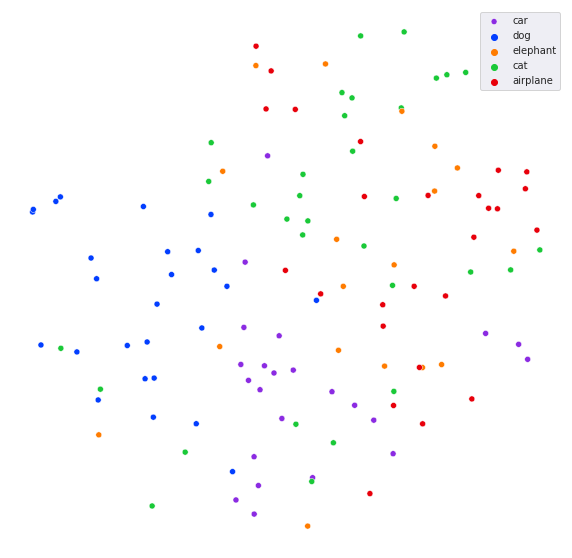

------------------TSNE visualizations of testing dataset-----------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


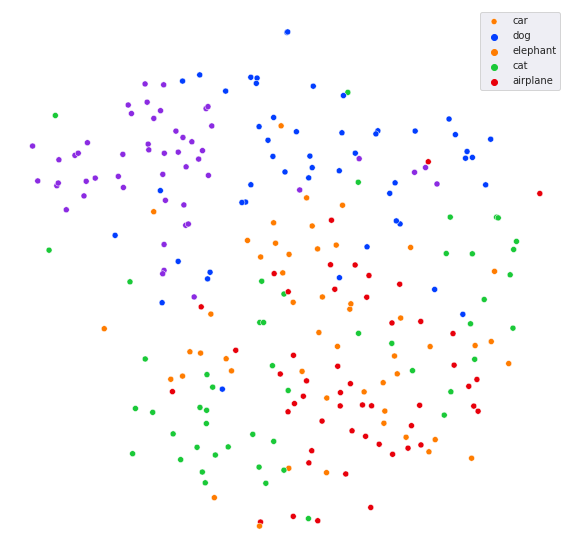

-----------------------TSNE_train_second_last_layer_dataset----------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


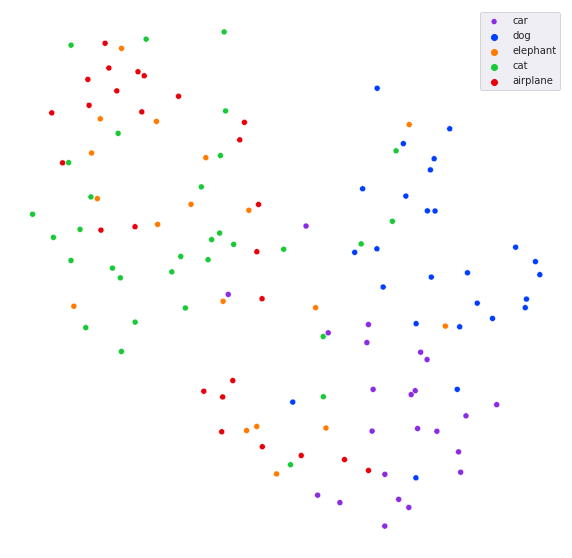

------------------------TSNE_test_second_last_layer_dataset----------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


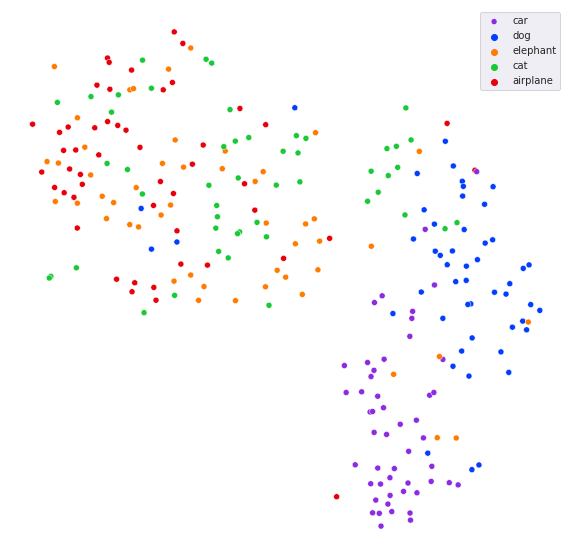

------------------------TSNE_hidden_train_dataset----------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


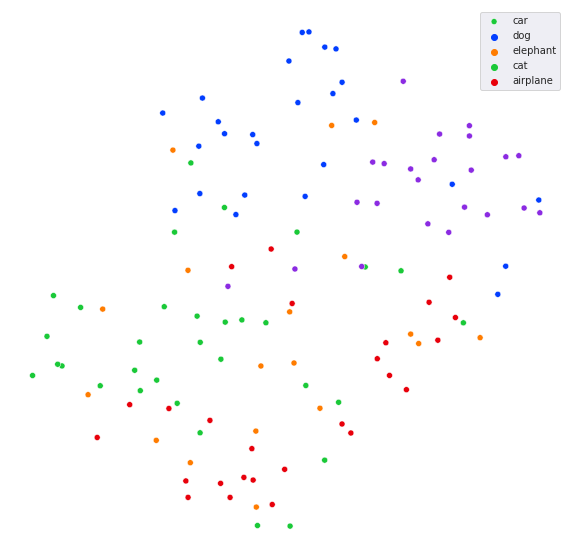

------------------------TSNE_hidden_test_dataset----------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


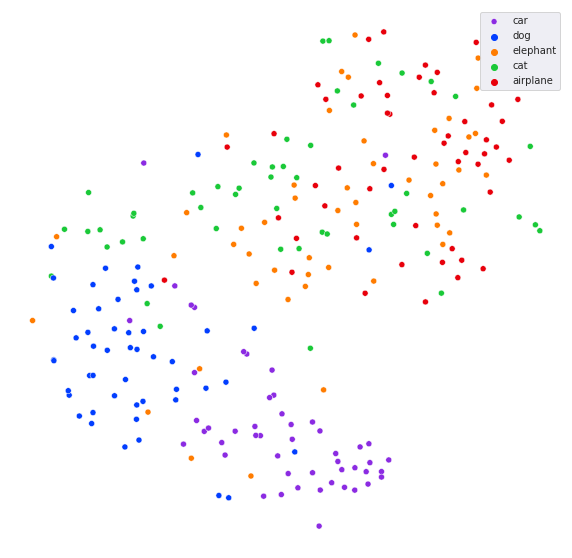

In [ ]:
# a function used to plot t-SNE visualizations
def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    # plt.style.use('classic')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.savefig(fname)
    plt.show()
    plt.close()

# Boolean variable to control whether to perform t-SNE visualization or not
TSNEVIS = True

if TSNEVIS:
    # run resnet in eval mode
    resnet.eval()

    # get TSNE visualizations of 10% training dataset
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        print('------------------TSNE visualizations of 10% training dataset------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None
        

    # get TSNE visualizations of testing dataset
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        print('------------------TSNE visualizations of testing dataset-----------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None
        


# # Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        print('-----------------------TSNE_train_second_last_layer_dataset----------------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        print('------------------------TSNE_test_second_last_layer_dataset----------------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# # removing one more layer, our entire projection head will be removed after this
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        print('------------------------TSNE_hidden_train_dataset----------------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        print('------------------------TSNE_hidden_test_dataset----------------------------')
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

### Perform Linear Classifier with visualization

In [ ]:
# Boolean variable to control whether to train the linear classifier or not
LINEAR = True

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 5)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

if LINEAR:

    if not os.path.exists('linear'):
        os.makedirs('linear')

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
    linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

    #number of epochs
    num_epochs_linear = 10

    # Boolean variable to control training of linear classifier
    # Trained using the trained model.pth and optimizer.pth
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0

    # if a model exists in the linear folder, load it
    if(os.path.isfile("linear/model.pth")):

        # load state dict for linear model and optimizer
        linear_classifier.load_state_dict(torch.load("linear/model.pth"))
        linear_optimizer.load_state_dict(torch.load("linear/optimizer.pth"))

        # change learning rate, you can change its values if you don't feel its necessity while training
        for g in linear_optimizer.param_groups:
          g['lr'] = 0.001
          g['weight_decay'] = 0

        # load data structures
        temp = np.load("linear/linear_losses_train_file.npz")
        losses_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_losses_test_file.npz")
        losses_test_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_train_file.npz")
        acc_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_test_file.npz")
        acc_test_linear = list(temp['arr_0'])

    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0

            # for loop for running through each batch
            for (_, sample_batched) in enumerate(dataloader_training_dataset):

                # get x and y from the batch
                x = sample_batched['image']
                y_actual = sample_batched['label']

                # move them to the device
                x = x.to(device)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = resnet(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None

            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(dataloader_testing_dataset):
            x = sample_batched['image']
            y_actual = sample_batched['label']

            x = x.to(device)
            y_actual  = y_actual.to(device)

            y_intermediate = resnet(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

            # calculate test_acc
            test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
            print("\nStart of epoch %d" % (epoch,), test_acc)

print("\nEpoch completed")


Start of epoch 0 0.636

Start of epoch 1 0.636

Start of epoch 2 0.636

Start of epoch 3 0.636

Start of epoch 4 0.636

Start of epoch 5 0.636

Start of epoch 6 0.636

Start of epoch 7 0.636

Start of epoch 8 0.636

Start of epoch 9 0.632

Epoch completed


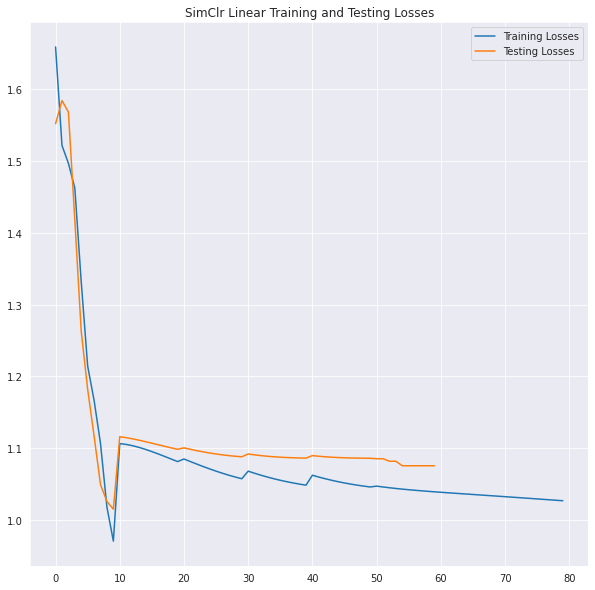

In [ ]:
if LINEAR_TRAINING:
    losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
    acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

    # plotting losses and accuracies
    fig = plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(losses_train_linear)
    plt.plot(losses_test_linear)
    plt.legend(['Training Losses', 'Testing Losses'])
    plt.title('SimClr Linear Training and Testing Losses')
    plt.savefig('linear/losses.png')
    plt.show()
    plt.close()

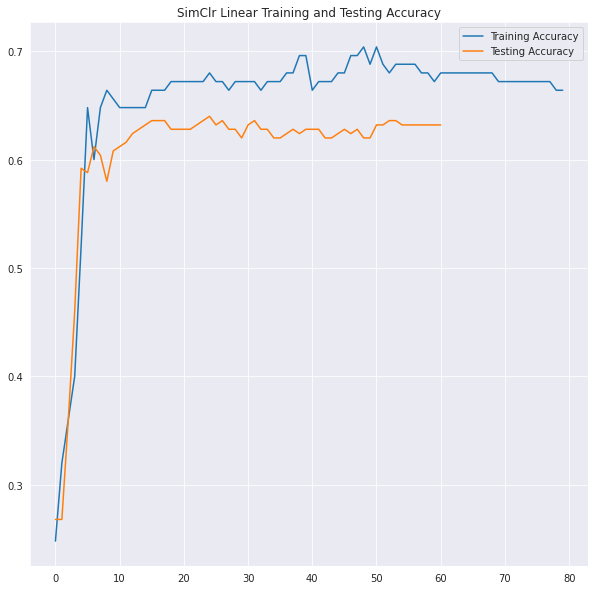

In [ ]:
if LINEAR_TRAINING:
    losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
    acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

    # plotting accuracies
    fig = plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(acc_train_linear)
    plt.plot(acc_test_linear)
    plt.legend(['Training Accuracy', 'Testing Accuracy'])
    plt.savefig('linear/accuracy.png')
    plt.title('SimClr Linear Training and Testing Accuracy')
    plt.show()
    plt.close()

    if test_acc >= max_test_acc:

        # save the model only when test_acc exceeds the current max_test_acc

        max_test_acc = test_acc
        torch.save(linear_classifier.state_dict(), 'linear/model.pth')
        torch.save(linear_optimizer.state_dict(), 'linear/optimizer.pth')

# save data structures
np.savez("linear/linear_losses_train_file", np.array(losses_train_linear))
np.savez("linear/linear_losses_test_file", np.array(losses_test_linear))
np.savez("linear/linear_acc_train_file", np.array(acc_train_linear))
np.savez("linear/linear_acc_test_file", np.array(acc_test_linear))